In [185]:
from operator import itemgetter
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import math
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.datasets import load_digits
from typing import Dict, Tuple
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


In [130]:
from enum import Enum
class PredictionType(Enum):
    CLASSIFICATION = 1
    REGRESSION = 2

In [131]:
class SimpleKNN:
    
    def fit(self, X_train: np.matrix, y_train: np.ndarray):
        """
        Метод обучения, который фактически не учится, 
        а только запоминает обучающую выборку.
        Входные параметры:
        X_train - обучающая выборка (матрица объект-признак)
        y_train - обучающая выборка (вектор целевого признака)
        Возвращаемое значение: нет
        """
        #Сохраняем параметры в переменных класса
        self._X_train = X_train
        self._y_train = y_train
          
    def eucl_dist(self, p: np.ndarray, q: np.ndarray) -> float:
        """
        Вычисление Евклидова расстояния - https://en.wikipedia.org/wiki/Euclidean_distance 
        Входные параметры:
        p, q - вектора в n-мерном пространстве признаков
        """
        return math.sqrt(sum([(pi - qi) ** 2 for pi, qi in zip (p, q)]))
            
            
    def predict_for_single_object(self, K: int, \
                prediction_type: PredictionType, \
                X_o: np.ndarray, \
                verbose = True) -> np.ndarray:
        """
        Метод предсказания для одного объекта.
        Входные параметры:
        K - гиперпараметр, количество соседей 
        prediction_type - классификация или регрессия 
        X_o - строка матрицы объект-признак, соответствующая объекту
        verbose - флаг детального вывода
        Возвращаемое значение: предсказанное значение целевого признака
        """
        # список соседей
        neighbors_list = []
        # *** Находим ближайшие точки ***
        # Перебираем все точки обучающей выборки
        for i in range(self._X_train.shape[0]):
            # получаем текущую точку
            data_train_current_x = [x for x in self._X_train[['x1','x2']].iloc[i]]
            # и значение ее y
            data_train_current_y = self._y_train[i]
            # вычисляем расстояние
            dist = self.eucl_dist(X_o, data_train_current_x)
            # сохраняем в список соседей
            temp_res = (data_train_current_y, dist, data_train_current_x)
            neighbors_list.append(temp_res)
        # *** сортируем список соседей по возрастанию расстояния *** 
        # в кортеже элементы следуют в порядке (0,1,2), сортируем по первому элементу 
        neighbors_list_sorted = sorted(neighbors_list, key=itemgetter(1))
        if verbose:
            print()
            print('**************************************')
            print('Проверяемая точка: ', X_o)
            print('**************************************')
            print('Вывод отсортированного списка соседей:')    
            dist_list = []
            for cur_y, cur_dist, temp_x_1_2 in neighbors_list_sorted:
                temp_x1, temp_x2 = temp_x_1_2
                print('X1={0}, X2={1}, y={2}, расстояние={3:.2f}'.format(temp_x1, temp_x2, cur_y, cur_dist))
                dist_list.append(cur_dist)
            print()
            print('Вывод расстояния для отсортированного списка соседей:')    
            plt.plot(dist_list)
            plt.show()
        # Оставим только K ближайших соседей
        K_neighbors_list_sorted = neighbors_list_sorted[:K]
        if verbose:
            print('Вывод К ближайших соседей:')
            x1_list = []
            x2_list = []
            for cur_y, cur_dist, temp_x_1_2 in K_neighbors_list_sorted:
                temp_x1, temp_x2 = temp_x_1_2
                x1_list.append(temp_x1)
                x2_list.append(temp_x2)
                print('X1={0}, X2={1}, y={2}, расстояние={3:.2f}'.format(temp_x1, temp_x2, cur_y, cur_dist))
            print()
            print('Визуализация К ближайших соседей:')
            plt.plot(self._X_train['x1'], self._X_train['x2'], 'b.', \
                     x1_list, x2_list,  'g*', \
                    [X_o[0]], [X_o[1]], 'ro')
            plt.show()   
        # Результат - классификация или регрессия
        if prediction_type == PredictionType.REGRESSION:
            # используем numpy для вычисления среднего значения
            arr = np.array([x for x,_,_ in K_neighbors_list_sorted])
            # возвращаем среднее значение
            return np.mean(arr)          
        elif prediction_type == PredictionType.CLASSIFICATION:
            k_y_list = [y for y,_,_ in K_neighbors_list_sorted]
            # группируем с количеством метки классов,
            # соответствующие K ближайшим соседям
            k_y_list_grouped_temp = np.unique(k_y_list, return_counts=True)
            k_y_list_grouped = [[key, cnt] for key, cnt in zip(k_y_list_grouped_temp[0], k_y_list_grouped_temp[1])]
            # сортируем по количеству по убыванию
            k_y_list_grouped_sorted = sorted(k_y_list_grouped, key=itemgetter(1), reverse=True)
            if verbose:
                print('Классы, соответствующие К ближайшим соседям:')
                for i in k_y_list_grouped_sorted:
                    print('класс={0}, количество элементов={1}'.format(i[0], i[1]))
            # возвращаеv метку класса из первой строки отсортированного массива
            # то есть того класса, к которому принадлежит наибольшее количество соседей
            return k_y_list_grouped_sorted[0][0]
        else:
            raise Exception('Неизвестный тип предсказания')
                   
    
    def predict(self, K: int, \
                prediction_type: PredictionType, \
                X_test: np.matrix, 
                verbose = True) -> np.ndarray:
        """
        Метод предсказания.
        Входные параметры:
        K - гиперпараметр, количество соседей 
        prediction_type - классификация или регрессия 
        X_test - тестовая выборка (матрица объект-признак)
        Возвращаемое значение: предсказанный вектор целевого признака
        """
        # Перебираем все точки тестовой выборки
        test_data_temp = []
        for i in range(X_test.shape[0]):
            # получаем текущую точку
            data_test_current_x = [x for x in X_test.iloc[i]]
            test_data_temp.append(data_test_current_x)       
        return [self.predict_for_single_object(K=K, \
                prediction_type=prediction_type, \
                X_o=i, verbose=verbose) for i in test_data_temp]

In [132]:
np.unique(housing.target)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [133]:
housing.data

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [134]:
housing.target_names

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [135]:
list(zip(np.unique(housing.target), housing.target_names))



[(0, 0),
 (1, 1),
 (2, 2),
 (3, 3),
 (4, 4),
 (5, 5),
 (6, 6),
 (7, 7),
 (8, 8),
 (9, 9)]

In [136]:
housing.target

array([0, 1, 2, ..., 8, 9, 8])

In [137]:
housing_df = pd.DataFrame(data= np.c_[housing['data'], housing['target']],
                     columns= housing['feature_names'] + ['target'])


In [138]:
housing_df.describe()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,target
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496,4.490818
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122,2.865304
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000,2.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000,4.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000,7.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,9.000000


In [139]:
housing_X_train, housing_X_test, housing_y_train, housing_y_test = train_test_split(
    housing.data, housing.target, test_size=0.5, random_state=1)

In [140]:
housing_X_train.shape, housing_y_train.shape

((898, 64), (898,))

In [141]:
housing_X_test.shape, housing_y_test.shape

((899, 64), (899,))

In [142]:
np.unique(housing_X_train)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16.])

In [143]:
np.unique(housing_X_test)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16.])

In [144]:
cl1_1 = KNeighborsClassifier(n_neighbors=2)
cl1_1.fit(housing_X_train, housing_y_train)
target1_1 = cl1_1.predict(housing_X_test)
len(target1_1), target1_1



(899,
 array([1, 5, 0, 7, 1, 0, 6, 1, 5, 4, 9, 2, 7, 8, 4, 6, 9, 3, 7, 4, 7, 1,
        8, 6, 0, 9, 6, 1, 3, 7, 5, 9, 8, 3, 2, 8, 8, 1, 1, 0, 7, 9, 0, 0,
        8, 7, 2, 7, 4, 3, 4, 3, 4, 0, 4, 7, 0, 5, 5, 5, 2, 1, 7, 0, 5, 1,
        8, 3, 3, 4, 0, 3, 7, 4, 3, 4, 2, 9, 7, 3, 2, 5, 3, 4, 1, 5, 5, 2,
        5, 2, 2, 2, 2, 7, 0, 8, 1, 7, 4, 2, 3, 8, 2, 3, 3, 0, 2, 9, 3, 2,
        3, 2, 8, 1, 1, 9, 1, 2, 0, 4, 8, 5, 4, 4, 7, 6, 7, 6, 6, 1, 7, 5,
        6, 3, 8, 3, 7, 1, 8, 5, 3, 4, 7, 8, 5, 0, 6, 0, 6, 3, 7, 6, 5, 6,
        2, 2, 2, 3, 0, 7, 6, 5, 6, 4, 1, 0, 6, 0, 6, 4, 0, 9, 3, 8, 1, 2,
        3, 1, 9, 0, 7, 6, 2, 9, 3, 5, 3, 4, 6, 3, 3, 7, 4, 9, 2, 7, 6, 1,
        6, 8, 4, 0, 3, 1, 0, 9, 9, 9, 0, 1, 8, 6, 8, 0, 9, 5, 9, 8, 2, 3,
        5, 3, 0, 8, 7, 4, 0, 3, 3, 3, 6, 3, 3, 2, 9, 1, 6, 9, 0, 4, 2, 2,
        7, 9, 1, 6, 7, 6, 3, 7, 1, 9, 3, 4, 0, 6, 4, 8, 5, 3, 6, 3, 1, 4,
        0, 4, 4, 8, 7, 9, 1, 5, 2, 7, 0, 9, 0, 4, 4, 0, 1, 0, 6, 4, 2, 8,
        5, 0, 2, 6, 0, 1, 8, 2, 

In [145]:
cl1_2 = KNeighborsClassifier(n_neighbors=15)
cl1_2.fit(housing_X_train, housing_y_train)
target1_2 = cl1_2.predict(housing_X_test)
len(target1_2), target1_2

(899,
 array([1, 5, 0, 7, 1, 0, 6, 1, 5, 4, 9, 2, 7, 8, 4, 6, 9, 3, 7, 4, 7, 1,
        8, 6, 0, 7, 6, 1, 3, 7, 5, 9, 8, 3, 2, 8, 8, 1, 1, 0, 7, 9, 0, 0,
        8, 7, 2, 7, 4, 3, 4, 3, 4, 0, 4, 7, 0, 5, 5, 5, 2, 1, 7, 0, 5, 1,
        8, 3, 3, 4, 0, 3, 7, 4, 3, 4, 2, 9, 7, 3, 2, 5, 3, 4, 1, 5, 5, 2,
        5, 2, 2, 2, 2, 7, 0, 8, 1, 7, 4, 2, 3, 8, 2, 3, 3, 0, 2, 9, 5, 2,
        3, 2, 8, 1, 1, 9, 6, 2, 0, 4, 8, 5, 4, 4, 7, 6, 7, 6, 6, 1, 7, 5,
        6, 3, 8, 3, 7, 1, 8, 5, 3, 4, 7, 8, 5, 0, 6, 0, 6, 3, 7, 6, 5, 6,
        2, 2, 2, 3, 0, 7, 6, 5, 6, 4, 1, 0, 6, 0, 6, 4, 0, 9, 8, 8, 1, 2,
        3, 1, 9, 0, 7, 6, 2, 9, 3, 5, 3, 4, 6, 3, 3, 7, 4, 7, 2, 7, 6, 1,
        6, 8, 4, 0, 3, 1, 0, 9, 9, 9, 0, 1, 8, 6, 8, 0, 9, 5, 9, 8, 2, 3,
        5, 3, 0, 8, 7, 4, 0, 3, 3, 3, 6, 3, 3, 2, 9, 1, 6, 9, 0, 4, 2, 2,
        7, 9, 1, 6, 7, 6, 3, 7, 1, 9, 3, 4, 0, 6, 4, 8, 5, 3, 6, 3, 2, 4,
        0, 4, 4, 8, 7, 9, 1, 5, 2, 7, 0, 9, 0, 4, 4, 0, 1, 4, 6, 4, 2, 8,
        5, 0, 2, 6, 0, 1, 8, 2, 

In [146]:
accuracy_score(housing_y_test, target1_1)


0.9755283648498332

In [147]:
accuracy_score(housing_y_test, target1_2)

0.9566184649610678

In [148]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

In [149]:
print_accuracy_score_for_classes(housing_y_test, target1_1)

Метка 	 Accuracy
0 	 1.0
1 	 0.989247311827957
2 	 0.9882352941176471
3 	 0.9693877551020408
4 	 1.0
5 	 0.9753086419753086
6 	 0.9886363636363636
7 	 1.0
8 	 0.9506172839506173
9 	 0.900990099009901


In [150]:
print_accuracy_score_for_classes(housing_y_test, target1_2)

Метка 	 Accuracy
0 	 0.9879518072289156
1 	 0.9032258064516129
2 	 0.9764705882352941
3 	 0.9591836734693877
4 	 0.99
5 	 0.9629629629629629
6 	 1.0
7 	 1.0
8 	 0.9259259259259259
9 	 0.8712871287128713


/home/anzhela/1cloud/1cloud/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


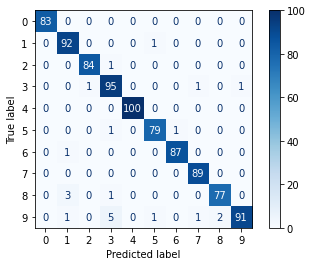

In [151]:
plot_confusion_matrix(cl1_1, housing_X_test, housing_y_test, 
                      display_labels=housing.target_names, cmap=plt.cm.Blues)



/home/anzhela/1cloud/1cloud/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


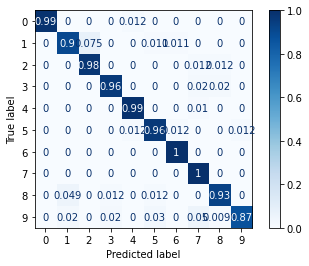

In [152]:
plot_confusion_matrix(cl1_2, housing_X_test, housing_y_test, 
                      display_labels=housing.target_names, cmap=plt.cm.Blues, normalize = "true")


/home/anzhela/1cloud/1cloud/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/anzhela/1cloud/1cloud/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


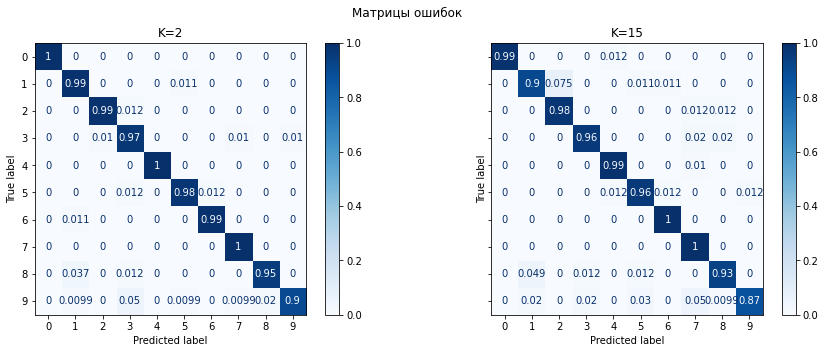

In [153]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,5))
plot_confusion_matrix(cl1_1, housing_X_test, housing_y_test, 
                      display_labels=housing.target_names, cmap=plt.cm.Blues, normalize = "true", ax=ax[0])
plot_confusion_matrix(cl1_2, housing_X_test, housing_y_test, 
                      display_labels=housing.target_names, cmap=plt.cm.Blues, normalize = "true", ax=ax[1])
fig.suptitle('Матрицы ошибок')
ax[0].title.set_text('K=2')
ax[1].title.set_text('K=15')

In [154]:
cl1_1.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Кросс-валидация

In [171]:
kf = KFold(n_splits=5)

In [172]:
scores = cross_val_score(KNeighborsClassifier(n_neighbors=2), housing.data, housing.target, scoring='f1_weighted', cv=kf)

In [173]:
scores

array([0.96422438, 0.96685658, 0.96918773, 0.97742711, 0.96353696])

In [174]:
kf = RepeatedKFold(n_splits=3, n_repeats =2)

# Подбор гиперпараметра

In [191]:
n_range = np.array(range(5, 55, 5))
tune_par = [{'n_neighbors': n_range}]
tune_par

[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}]

In [192]:
%%time
cls_gs = GridSearchCV(KNeighborsClassifier(), tune_par, cv=5, scoring = 'accuracy' )
cls_gs.fit(housing_X_train, housing_y_train)

CPU times: user 3.17 s, sys: 2.22 s, total: 5.39 s
Wall time: 2.63 s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}],
             scoring='accuracy')

In [193]:
cls_gs.cv_results_

{'mean_fit_time': array([0.04838142, 0.00159454, 0.00152321, 0.00146861, 0.00146556,
        0.00149274, 0.00145812, 0.00152216, 0.00278549, 0.00147009]),
 'std_fit_time': array([9.35082688e-02, 1.89131735e-04, 1.60959206e-05, 2.06098486e-05,
        1.92733073e-05, 2.26309347e-05, 8.78662748e-05, 4.42620994e-05,
        2.53287827e-03, 1.36069976e-05]),
 'mean_score_time': array([0.23326616, 0.02209501, 0.02182508, 0.02255764, 0.02156148,
        0.02176061, 0.02525697, 0.03322525, 0.02293329, 0.02282667]),
 'std_score_time': array([4.19852068e-01, 7.94534662e-04, 4.22266914e-04, 1.90262027e-03,
        3.01639535e-04, 2.04461057e-04, 4.18169392e-03, 1.31422868e-02,
        6.03586747e-04, 3.15899813e-04]),
 'param_n_neighbors': masked_array(data=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 5},
  {'n_

In [194]:
cls_gs.best_estimator_

KNeighborsClassifier()

In [195]:
cls_gs.best_params_

{'n_neighbors': 5}

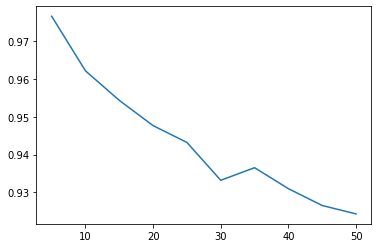

In [196]:
plt.plot(n_range, cls_gs.cv_results_['mean_test_score'] )

In [198]:
%%time
cls_rs = RandomizedSearchCV(KNeighborsClassifier(), tune_par, cv=5, scoring = 'accuracy' )
cls_rs.fit(housing_X_train, housing_y_train)

CPU times: user 3.05 s, sys: 1.93 s, total: 4.98 s
Wall time: 1.48 s


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(),
                   param_distributions=[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}],
                   scoring='accuracy')

In [199]:
cls_gs.best_params_

{'n_neighbors': 5}

# Сравнение метрик

In [200]:
cls_gs.best_score_

0.9766294227188081

In [201]:
accuracy_score(housing_y_test, target1_1)


0.9755283648498332